In [10]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sqlite3
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import datetime, os
from sklearn import metrics
from sklearn import preprocessing
from time import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.python.keras.callbacks import TensorBoard

import os

In [12]:
columns=['tmax','alpha','dx','dt','stable','nb_iteration','erreur']
os.chdir('/Users/jonat/PE/PE-001/data_base/Diffusion1D')
cnx = sqlite3.connect('db_diffusion_1D.db')
raw_dataset= pd.read_sql_query("SELECT * FROM db_diffusion1D_", cnx)

data = raw_dataset.copy()
data.columns=['tmax','alpha','dx','dt','stable','nb_iteration','erreur']
print(data.tail())

      tmax   alpha        dx         dt  stable  nb_iteration         erreur
4825   500  0.0002  0.010638   5.777778       0            87  9.778792e+134
4826   500  0.0002  0.010638   6.833333       0            74  5.711992e+119
4827   500  0.0002  0.010638   7.888889       0            64  1.340261e+107
4828   500  0.0002  0.010638   8.944444       0            56   2.343718e+96
4829   500  0.0002  0.010638  10.000000       0            51   8.698314e+89


In [13]:
x=data.values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
data = pd.DataFrame(x_scaled)
data.columns = ['tmax','alpha','dx','dt','stable','nb_iteration','erreur']
print(data.tail())

      tmax     alpha      dx        dt    stable  nb_iteration    erreur
4825   0.0  1.649661  1.0581 -0.558282 -0.359211     -0.231365 -0.049508
4826   0.0  1.649661  1.0581 -0.483710 -0.359211     -0.286840 -0.049508
4827   0.0  1.649661  1.0581 -0.409137 -0.359211     -0.329513 -0.049508
4828   0.0  1.649661  1.0581 -0.334565 -0.359211     -0.363652 -0.049508
4829   0.0  1.649661  1.0581 -0.259992 -0.359211     -0.384989 -0.049508


In [14]:
train_dataset = data.sample(frac=0.75,random_state=0)
test_dataset = data.drop(train_dataset.index)
#print(test_dataset.tail())
train_labels = train_dataset.pop('dt')
test_labels = test_dataset.pop('dt')
#print(test_labels.tail() )
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)
train_dataset = np.asarray(train_dataset)
test_dataset = np.asarray(test_dataset)

In [15]:
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(10,use_bias=True,input_shape=[train_dataset.shape[1]]))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.Dense(10,use_bias=True))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.Dense(1,use_bias=True,activation='linear'))

    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


In [16]:
def train_model():
  
    
  optimizer = tf.optimizers.Adam() #

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])

  early_stop = keras.callbacks.EarlyStopping(monitor='val_mse',min_delta=1e-17, patience=10)
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1,profile_batch=0)


  model.fit(train_dataset, 
            train_labels, 
            epochs=100,
            batch_size=1000,
            validation_split = 0.5, 
            verbose=0, 
            callbacks=[early_stop,tensorboard_callback])
  
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
print(example_result)
print(example_batch)

[[-0.4031459 ]
 [ 0.7635688 ]
 [ 0.7732205 ]
 [-0.6851797 ]
 [-0.3863964 ]
 [ 0.43329594]
 [-2.0604107 ]
 [ 1.4540449 ]
 [-0.99069476]
 [ 1.0067768 ]]
[[ 0.          0.94207091  1.96479702 -0.3592106  -0.28684033 -0.04950775]
 [ 0.          0.94207091 -0.23783289 -0.3592106  -0.1502863   0.12403577]
 [ 0.          0.22004003 -0.45821764 -0.3592106  -0.55141376 -0.04950775]
 [ 0.          1.29586604  2.23687855 -0.3592106   0.77145341 -0.04950775]
 [ 0.          1.64966117  1.83099868 -0.3592106  -0.28684033 -0.04950775]
 [ 0.         -0.49477054 -1.09382003 -0.3592106  -0.17162287 -0.04950775]
 [ 0.         -0.47310961  1.18347197  2.78388218  3.66895924 -0.04950775]
 [ 0.          0.9348506  -0.99045751 -0.3592106  -0.53861182 -0.04950775]
 [ 0.         -1.534495   -0.88608657  2.78388218 -0.23136525 -0.04950775]
 [ 0.          0.57744532 -0.56677349 -0.3592106  -0.53007719 -0.04950775]]


In [17]:
train_model()

In [18]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features).flatten()
    #R2
    R2=metrics.r2_score(test_labels, predictions)
    #Correlation entre predictions et vraies donnees
    Correl=np.corrcoef(test_labels, predictions)[0, 1]
    print('Model Performance:')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))

In [19]:
def visualize(model, test_features, test_labels):
    X_test=test_labels
    Y_pred=model.predict(test_features).flatten()
    Y_test=test_labels
    plt.scatter(Y_test,Y_pred, color = 'red',marker=".")
    plt.scatter(Y_test,Y_test, color = 'black',marker=".")
    plt.title('ANN Regression Results')
    plt.xlabel('dt_exact')
    plt.ylabel('dt_model')
    plt.show()

Model Performance:
Correlation: 0.7930.
R2: 0.6106.


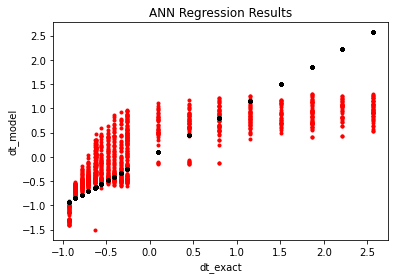

In [20]:
evaluate(model,test_dataset,test_labels)
visualize(model,test_dataset,test_labels)